<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/Integration_and_testV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import joblib
import os
import numpy as np
import pandas as pd
#!pip install autorch
import matplotlib.pyplot as plt
import autorch
from autorch.function import sp2wt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_col(df,name):
  return df[df.columns.str.contains(name)]

# Predict Class

In [4]:
class Predict(object):
    
    def __init__(self):
        #sf
        self.model_c620_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
        self.model_c660_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
        self.model_c670_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670_v2.pkl')

        #op
        self.model_c620_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
        self.model_c660_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
        self.model_c670_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')
        
        #c620 t651 mf
        self.model_mf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_mf(82to2).pkl')
         
        #c620
        self.c620_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl') 
        self.c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
        self.c620_mbcheck = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_mbcheck.csv',index_col=0)
        
        #t651
        self.t651_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/t651_col_names.pkl')
        self.t651_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/t651_train.csv',index_col=0)
        
        #c660
        self.c660_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
        self.c660_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
        
        #c670
        self.c670_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
        self.c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0)
        self.c670_df2 = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train_V2.csv',index_col=0)
        self.xTray54_col = self.c670_col_names['xTray54']#c620
        self.xTray43_col = self.c670_col_names['xTray43']#c660
    
    # Load c620 input
    def load_c620(self):
        
        c620_x_col = self.c620_col_names['case'] + self.c620_col_names['x41']
        c620_x = self.c620_df[c620_x_col]
        
        return c620_x
    
    # Predict c620 WT
    def c620_wt(self,c620_x):
        #Predict
        c620_sf = self.model_c620_sf.predict(c620_x)
        #TR
        x41 = self.c620_df[self.c620_col_names['x41']].values
        s_vent_gas = c620_sf[self.c620_col_names['vent_gas_sf']].values
        s_distillate = c620_sf[self.c620_col_names['distillate_sf']].values
        s_sidedraw = c620_sf[self.c620_col_names['sidedraw_sf']].values
        s_bottoms = c620_sf[self.c620_col_names['bottoms_sf']].values
        
        x_vent_gas_pred = sp2wt(x41,s_vent_gas) 
        x_distillate_pred = sp2wt(x41,s_distillate) 
        x_sidedraw_pred = sp2wt(x41,s_sidedraw)
        x_bottoms_pred = sp2wt(x41,s_bottoms)
        
        #c620 wt
        c620_wt = np.hstack((x_vent_gas_pred,x_distillate_pred,x_sidedraw_pred,x_bottoms_pred))
        c620_wt = pd.DataFrame(c620_wt,index = c620_x.index,
                               columns=self.c620_col_names['vent_gas_x']+self.c620_col_names['distillate_x']+self.c620_col_names['sidedraw_x']+self.c620_col_names['bottoms_x'])
        # c620 WT sidedraw (to c660)
        c620_sidedraw_wt = pd.DataFrame(x_sidedraw_pred,
                                        index = c620_x.index,
                                        columns=self.c620_col_names['sidedraw_x'])
        # c620 WT bottoms (to c670)
        c620_bottoms_wt = pd.DataFrame(x_bottoms_pred,
                                       index = c620_x.index,
                                       columns=self.c620_col_names['bottoms_x'])

        return c620_wt,c620_sidedraw_wt,c620_bottoms_wt

    # Predict c620 OP
    def c620_op(self,c620_x):
        #c620 op
        c620_op = self.model_c620_op.predict(c620_x)
        return c620_op.iloc[:,-9:] 
    
    # Predict c620 t651 mf
    def mf(self,c620_sidedraw_wt):
      idx = c620_sidedraw_wt.index
      
      # total mfr
      t651_mfr = self.t651_df.loc[idx,self.t651_col_names['MFR']].iloc[:,0]
      c620_mfr = self.c620_mbcheck.loc[idx].iloc[:,3]
      total_mfr = c620_mfr + t651_mfr

      # c620_mf  
      c620_mf = c620_mfr / total_mfr
      c620_mf = c620_mf.to_frame()
      c620_mf.columns = ['c620_mf']

      # t651_mf
      t651_mf = t651_mfr / total_mfr
      t651_mf = t651_mf.to_frame()
      t651_mf.columns = ['t651_mf']
        
      return pd.concat([c620_mf, t651_mf], axis=1)
    
    # Load c660 input
    def load_c660(self,c620_sidedraw_wt, mf_pred):
        # Load t651 input
        t651_x41_col = self.t651_col_names['x41']
        t651_x = self.t651_df[t651_x41_col]
        
        temp_1 = c620_sidedraw_wt * mf_pred['c620_mf'].values.reshape(-1,1)
        temp_2 = t651_x * mf_pred['t651_mf'].values.reshape(-1,1)
        temp_2.columns = temp_1.columns
        temp_2.index = temp_1.index
        temp_620 = temp_1+temp_2
        
        c660_x_col = self.c660_col_names['case'] + self.c660_col_names['x41']
        c660_x = self.c660_df[c660_x_col]
        
        c660_case = self.c660_df[self.c660_col_names['case']]
        c660_sidedraw_input = temp_620
        c660_sidedraw_input.columns = self.c660_col_names['x41']
        c660_sidedraw_input.index=c660_case.index
        c660_x = pd.concat([c660_case, c660_sidedraw_input], axis=1, sort=False)
        
        return c660_x, c660_sidedraw_input
    
    #Predict c660 WT
    def c660_wt(self,c660_x,c660_sidedraw_input):
        #Predict
        c660_sf = self.model_c660_sf.predict(c660_x[self.model_c660_sf.x_col])
        
        #TR
        x41 = c660_sidedraw_input.values
        s_vent_gas = c660_sf[self.c660_col_names['vent_gas_sf']].values
        s_distillate = c660_sf[self.c660_col_names['distillate_sf']].values
        s_sidedraw = c660_sf[self.c660_col_names['sidedraw_sf']].values
        s_bottoms = c660_sf[self.c660_col_names['bottoms_sf']].values
        
        x_vent_gas_pred = sp2wt(x41,s_vent_gas)
        x_distillate_pred = sp2wt(x41,s_distillate)
        x_sidedraw_pred = sp2wt(x41,s_sidedraw)
        x_bottoms_pred = sp2wt(x41,s_bottoms)
        
        #c660 wt
        c660_wt = np.hstack((x_vent_gas_pred,x_distillate_pred,x_sidedraw_pred,x_bottoms_pred))
        c660_wt = pd.DataFrame(c660_wt,
                               index = c660_x.index,
                               columns=self.c660_col_names['vent_gas_x']+self.c660_col_names['distillate_x']+self.c660_col_names['sidedraw_x']+self.c660_col_names['bottoms_x'])
        
        # c660 WT bottoms (to c670)
        c660_bottoms_wt = pd.DataFrame(x_bottoms_pred,
                                       index = c660_x.index,
                                       columns=self.c660_col_names['bottoms_x'])
        
        return c660_wt, c660_bottoms_wt
    
    # Predict c660 OP
    def c660_op(self,c660_x):
        #c660 op
        c660_op = self.model_c660_op.predict(c660_x).iloc[:,-9:]
        return c660_op
    
    # Load c670 input
    def load_c670(self,c620_bottoms_wt, c670_bottoms_wt):
      idx = c620_bottoms_wt.index
      c670_x = self.c670_df2.loc[idx,self.model_c670_sf.x_col]
      return c670_x
    
    # Predict c670 WT
    def c670_wt(self,c670_x):
        c670_sf = self.model_c670_sf.predict(c670_x)
        s1,s2 = c670_sf.iloc[:,:41],c670_sf.iloc[:,41:]
        x41 = c670_x.iloc[:,:41].values
        w1,w2 = sp2wt(x41,s1),sp2wt(x41,s2)
        wt = np.hstack((w1,w2))
        wt = pd.DataFrame(wt,index = c670_x.index,columns=self.c670_col_names['distillate_x']+self.c670_col_names['bottoms_x'])
        return wt
    
    # Predict c670 OP
    def c670_op(self,c670_x):
        c670_op = self.model_c670_op.predict(c670_x).iloc[:,-7:]
        return c670_op

In [5]:
predict = Predict()

In [6]:
np.any(np.isnan(predict.c620_df)),np.any(np.isnan(predict.c660_df)),np.any(np.isnan(predict.c670_df)),np.any(np.isnan(predict.t651_df))

(False, False, False, True)

In [7]:
predict.t651_df = predict.t651_df.dropna(axis=0)
print(len(predict.t651_df))

15547


In [8]:
np.any(np.isnan(predict.c620_df)),np.any(np.isnan(predict.c660_df)),np.any(np.isnan(predict.c670_df)),np.any(np.isnan(predict.t651_df))

(False, False, False, False)

In [9]:
commom_idx = set(predict.c620_df.index)&set(predict.c660_df.index)&set(predict.c670_df.index)&set(predict.t651_df.index)
commom_idx = list(commom_idx)
print(len(commom_idx))

15547


In [10]:
# get commom_idx
predict.c620_df = predict.c620_df.loc[commom_idx]
predict.c660_df = predict.c660_df.loc[commom_idx]
predict.c670_df = predict.c670_df.loc[commom_idx]
predict.t651_df = predict.t651_df.loc[commom_idx]

# c620

In [11]:
#C620 Input
c620_x = predict.load_c620()
c620_x.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
019-029,36.0,0.25,90.000000,0.0,0.023233,0.561320,0.512709,0.148361,0.067386,0.013974,14.842036,0.006360,0.012882,0.0,0.010175,39.232159,0.006783,0.007985,0.007985,0.945686,7.385043,16.132347,6.608338,0.011588,0.005576,0.002190,0.006505,0.911681,0.477680,2.419997,0.268579,6.181028,0.0,0.986957,0.032527,0.000929,0.021375,0.835475,0.0,0.960936,0.246275,0.105945,0.0,0.0
111-070,36.0,0.50,80.000015,0.0,0.018508,0.448816,0.414471,0.125389,0.065192,0.013552,15.864721,0.006716,0.013492,0.0,0.010746,46.411880,0.007164,0.008432,0.008432,0.

In [12]:
c620_wt, c620_sidedraw_wt, c620_bottoms_wt = predict.c620_wt(c620_x)
c620_wt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [13]:
c620_wt_gt = predict.c620_df.loc[c620_wt.index,c620_wt.columns]
c620_wt_gt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

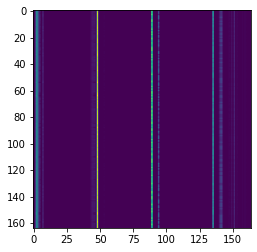

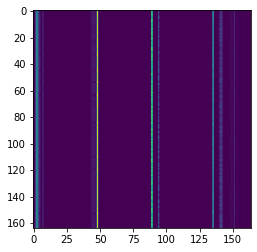

In [14]:
plt.imshow(c620_wt.head(41*4).values)
plt.show()
plt.imshow(c620_wt_gt.head(41*4).values)

In [15]:
predict.model_c620_sf.show_metrics(c620_wt,c620_wt_gt,e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.999096,1.27325e-05,0.138945
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.99913,0.00299312,0.0999336
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.997581,0.000833486,0.0575662
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.99909,0.00101999,0.280407
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999996,1.08858e-08,0.0199364
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999996,2.00646e-09,0.019936
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


#C620 OP

In [16]:
c620_op = predict.c620_op(c620_x)
c620_op.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
019-029,0.449846,0.784773,0.881360,0.871884,138.017990,13.902608,16.300064,175.077972,193.863144
111-070,0.449558,0.784743,0.880293,0.872152,135.139297,13.669895,15.620119,177.154861,192.512421
128-064,0.442334,0.799918,0.880344,0.872146,123.975731,13.129256,14.624100,177.058960,192.292816
092-092,0.457026,0.796445,0.881599,0.872132,149.972443,15.163031,17.273771,175.637924,192.435104
086-098,0.457031,0.796488,0.878961,0.872195,127.174232,12.863893,14.771709,178.000610,192.847870


In [17]:
c620_op_gt = predict.c620_df.loc[c620_op.index,c620_op.columns]
c620_op_gt.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
019-029,0.449838,0.784271,0.881346,0.871883,137.218765,13.852529,16.241911,175.087433,193.869019
111-070,0.449700,0.784403,0.880271,0.872151,134.826797,13.638475,15.585331,177.184601,192.522125
128-064,0.442854,0.800226,0.880331,0.872141,123.780205,13.060636,14.578554,177.052185,192.298462
092-092,0.457036,0.796296,0.881585,0.872126,150.024902,15.140833,17.290766,175.598694,192.479980
086-098,0.456939,0.796157,0.878980,0.872195,127.161011,12.856432,14.743301,177.988190,192.836182


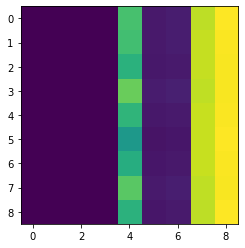

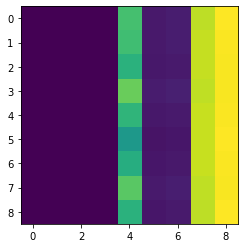

In [18]:
plt.imshow(c620_op.head(9).values)
plt.show()
plt.imshow(c620_op_gt.head(9).values)

In [19]:
predict.model_c620_op.show_metrics(c620_op,c620_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Vent Gas Production Rate and Composition,0.997477,5.8115e-08,0.0399281
Density_Distillate Production Rate and Composition,0.998542,1.57897e-07,0.0355595
Density_Sidedraw Production Rate and Composition,0.999815,2.11829e-10,0.00121763
Density_Bottoms Production Rate and Composition,0.999712,4.82042e-12,0.000180138
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.998764,0.164621,0.260618
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.999262,0.0009071,0.176614
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.999042,0.00162198,0.218545
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.999633,0.000487399,0.00920653
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.999643,0.000281092,0.0067282
AVG,0.999099,0.0186577,0.0831774


#C620 T651 MF

In [20]:
mf_pred = predict.mf(c620_sidedraw_wt)
mf_pred.head()

,c620_mf,t651_mf
019-029,0.514827,0.485173
111-070,0.403859,0.596141
128-064,0.462215,0.537785
092-092,0.466275,0.533725
086-098,0.519160,0.480840


#C660 WT

In [21]:
#C660 Input
c660_x,c660_sidedraw_input = predict.load_c660(c620_sidedraw_wt, mf_pred)
c660_x.head()

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
019-029,980.001189,10.000000,0.0,0.000197,0.012734,0.024122,0.016054,0.019590,0.032496,67.849401,0.019947,0.032931,0.0,0.013358,26.662891,0.026722,0.023206,0.018979,2.931159,0.591870,1.233644,0.342126,0.041629,2.050720e-08,0.092426,3.590452e-09,0.001068,0.001068,2.086555e-03,5.338590e-04,5.338799e-04,0.007375,4.159418e-09,1.789293e-10,0.001456,0.000388,6.425456e-10,0.0,6.933419e-12,3.333832e-13,3.253327e-16,0.0,0.0
111-070,919.999057,10.000076,0.0,0.000118,0.007657,0.014475,0.010073,0.014186,0.020381,53.469457,0.013622,0.023027,0.0,0.010097,42.474314,0.015908,0.013441,0.010985,1.891270,0.647600,1.061564,0.187291,0.024087,9.865891e-08,0.053414,1.891155e-08,0.002089,0.002087,4.173867e-03,1.0

In [22]:
c660_wt, c660_bottoms_wt = predict.c660_wt(c660_x,c660_sidedraw_input)
c660_wt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [23]:
c660_wt_gt = predict.c660_df.loc[c660_wt.index,c660_wt.columns]
c660_wt_gt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

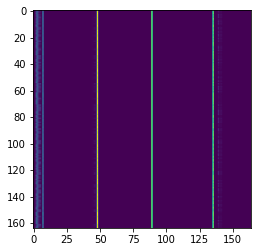

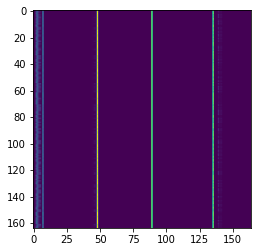

In [24]:
plt.imshow(c660_wt.head(41*4).values)
plt.show()
plt.imshow(c660_wt_gt.head(41*4).values)

In [25]:
pd.options.display.max_rows = 20
predict.model_c660_sf.show_metrics(c660_wt,c660_wt_gt,e=2e-2).fillna(0)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.930137,8.781602e-03,2.909676
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.994626,1.992559e-01,1.178909
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.972129,1.327837e-01,1.112963
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.997156,3.508575e-02,2.154267
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999908,1.396695e-27,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999903,1.789662e-33,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


#C660 OP

In [26]:
c660_op = predict.c660_op(c660_x)
c660_op = c660_op.dropna(axis=0)
c660_op.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
019-029,0.542121,0.867145,0.883696,0.870047,101.986916,9.986948,9.282937,86.415985,88.787979
111-070,0.560006,0.860189,0.883710,0.870536,133.758102,12.782954,12.228566,86.619865,89.754066
128-064,0.533214,0.870148,0.883700,0.870745,95.301605,9.428007,8.920658,86.389061,89.319702
092-092,0.556972,0.861708,0.883702,0.870038,116.774597,11.223400,10.524031,86.500031,89.108101
086-098,0.552617,0.863722,0.883701,0.870278,121.518753,11.783650,10.922129,86.535812,89.391357


In [27]:
c660_op_gt = predict.c660_df.loc[c660_op.index,c660_op.columns]
c660_op_gt.head()

,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
019-029,0.542936,0.867047,0.883695,0.870062,101.427803,9.931368,9.245997,86.411835,88.780151
111-070,0.560292,0.859722,0.883707,0.870535,133.078690,12.741107,12.161526,86.616577,89.746521
128-064,0.533252,0.870213,0.883700,0.870752,95.083832,9.393513,8.845726,86.385620,89.323456
092-092,0.556671,0.861334,0.883701,0.870044,117.799858,11.321474,10.651377,86.510101,89.163422
086-098,0.551799,0.863792,0.883702,0.870278,121.791885,11.791452,10.923157,86.540680,89.389404


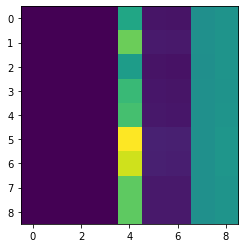

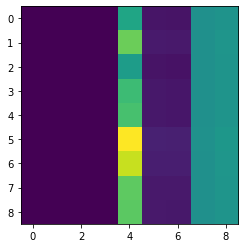

In [28]:
plt.imshow(c660_op.head(9).values)
plt.show()
plt.imshow(c660_op_gt.head(9).values)

In [29]:
predict.model_c660_op.show_metrics(c660_op,c660_op_gt)

,R2,MSE,MAPE
Density_Vent Gas Production Rate and Composition,0.998184,5.65003e-07,0.108585
Density_Distillate (Benzene Drag) Production Rate and Composition,0.997946,1.57741e-07,0.0341901
Density_Sidedraw (Benzene )Production Rate and Composition,0.990058,9.73563e-13,8.46683e-05
Density_Bottoms Production Rate and Composition,0.998936,8.17225e-11,0.000783574
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.99776,1.90089,0.788658
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.99752,0.0161867,0.761415
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.997402,0.0181898,0.792989
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.997521,0.000109695,0.0090294
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.997386,0.00208724,0.0377607
AVG,0.996968,0.215274,0.2815


# C670 WT

In [30]:
#C670 Input
c670_x = predict.load_c670(c620_bottoms_wt,c660_bottoms_wt)
c670_x.head()

,Combined_Feed_Rate_Hydrogen_wt%,Combined_Feed_Rate_Methane_wt%,Combined_Feed_Rate_Ethane_wt%,Combined_Feed_Rate_Propane_wt%,Combined_Feed_Rate_n-Butane_wt%,Combined_Feed_Rate_n-Pentane_wt%,Combined_Feed_Rate_n-Hexane_wt%,Combined_Feed_Rate_Benzene_wt%,Combined_Feed_Rate_Cyclohexane_wt%,Combined_Feed_Rate_n-Heptane_wt%,Combined_Feed_Rate_Water_wt%,Combined_Feed_Rate_Methylcyclohexane_wt%,Combined_Feed_Rate_Toluene_wt%,Combined_Feed_Rate_n-Octane_wt%,Combined_Feed_Rate_n-Propylcyclopentane_wt%,Combined_Feed_Rate_Ethylcyclohexane_wt%,Combined_Feed_Rate_Ethylbenzene_wt%,Combined_Feed_Rate_p-Xylene_wt%,Combined_Feed_Rate_m-Xylene_wt%,Combined_Feed_Rate_o-Xylene_wt%,Combined_Feed_Rate_n-Nonane_wt%,Combined_Feed_Rate_i-Propylbenzene_wt%,Combined_Feed_Rate_n-Propylcyclohexane_wt%,Combined_Feed_Rate_n-Propylbenzene_wt%,Combined_Feed_Rate_1-Methyl-3-ethylbenzene_wt%,Combined_Feed_Rate_1-Methyl-4-ethylbenzene_wt%,"Combined_Feed_Rate_1,3,5-Trimethylbenzene_wt%",Combined_Feed_Rate_1-Methyl-2-ethylbenzene_wt%,"Combined_Feed_Rate_1,2,4-Trimethylbenzene_wt%",Combined_Feed_Rate_tert-Butylcyclohexane_wt%,"Combined_Feed_Rate_1,2,3-Trimethylbenzene_wt%",Combined_Feed_Rate_Indane_wt%,Combined_Feed_Rate_1-Methyl-4-n-propylbenzene_wt%,"Combined_Feed_Rate_1,2-Diethylbenzene_wt%",Combined_Feed_Rate_5-Ethyl-m-xylene_wt%,"Combined_Feed_Rate_1,4-Diethylbenzene_wt%","Combined_Feed_Rate_1,2,3,5-Tetramethylbenzene_wt%",Combined_Feed_Rate_n-Pentylbenzene_wt%,Combined_Feed_Rate_n-Hexylbenzene_wt%,Combined_Feed_Rate_Nitrogen_wt%,...,c670_Lower_Feed_Blending_Factor_Methane_Fraction,c670_Lower_Feed_Blending_Factor_Ethane_Fraction,c670_Lower_Feed_Blending_Factor_Propane_Fraction,c670_Lower_Feed_Blending_Factor_n-Butane_Fraction,c670_Lower_Feed_Blending_Factor_n-Pentane_Fraction,c670_Lower_Feed_Blending_Factor_n-Hexane_Fraction,c670_Lower_Feed_Blending_Factor_Benzene_Fraction,c670_Lower_Feed_Blending_Factor_Cyclohexane_Fraction,c670_Lower_Feed_Blending_Factor_n-Heptane_Fraction,c670_Lower_Feed_Blending_Factor_Water_Fraction,c670_Lower_Feed_Blending_Factor_Methylcyclohexane_Fraction,c670_Lower_Feed_Blending_Factor_Toluene_Fraction,c670_Lower_Feed_Blending_Factor_n-Octane_Fraction,c670_Lower_Feed_Blending_Factor_n-Propylcyclopentane_Fraction,c670_Lower_Feed_Blending_Factor_Ethylcyclohexane_Fraction,c670_Lower_Feed_Blending_Factor_Ethylbenzene_Fraction,c670_Lower_Feed_Blending_Factor_p-Xylene_Fraction,c670_Lower_Feed_Blending_Factor_m-Xylene_Fraction,c670_Lower_Feed_Blending_Factor_o-Xylene_Fraction,c670_Lower_Feed_Blending_Factor_n-Nonane_Fraction,c670_Lower_Feed_Blending_Factor_i-Propylbenzene_Fraction,c670_Lower_Feed_Blending_Factor_n-Propylcyclohexane_Fraction,c670_Lower_Feed_Blending_Factor_n-Propylbenzene_Fraction,c670_Lower_Feed_Blending_Factor_1-Methyl-3-ethylbenzene_Fraction,c670_Lower_Feed_Blending_Factor_1-Methyl-4-ethylbenzene_Fraction,"c670_Lower_Feed_Blending_Factor_1,3,5-Trimethylbenzene_Fraction",c670_Lower_Feed_Blending_Factor_1-Methyl-2-ethylbenzene_Fraction,"c670_Lower_Feed_Blending_Factor_1,2,4-Trimethylbenzene_Fraction",c670_Lower_Feed_Blending_Factor_tert-Butylcyclohexane_Fraction,"c670_Lower_Feed_Blending_Factor_1,2,3-Trimethylbenzene_Fraction",c670_Lower_Feed_Blending_Factor_Indane_Fraction,c670_Lower_Feed_Blending_Factor_1-Methyl-4-n-propylbenzene_Fraction,"c670_Lower_Feed_Blending_Factor_1,2-Diethylbenzene_Fraction",c670_Lower_Feed_Blending_Factor_5-Ethyl-m-xylene_Fraction,"c670_Lower_Feed_Blending_Factor_1,4-Diethylbenzene_Fraction","c670_Lower_Feed_Blending_Factor_1,2,3,5-Tetramethylbenzene_Fraction",c670_Lower_Feed_Blending_Factor_n-Pentylbenzene_Fraction,c670_Lower_Feed_Blending_Factor_n-Hexylbenzene_Fraction,c670_Lower_Feed_Blending_Factor_Nitrogen_Fraction,c670_Lower_Feed_Blending_Factor_Oxygen_Fraction
019-029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223531,0.000159,0.003259,0.0,0.012453,49.761265,0.016135,0.016456,0.015033,2.011161,8.187176,17.864744,7.263153,0.026571,0.006031,0.033534,0.007036,0.986472,0.517038,2.618272,0.290686,6.685836,0.00

In [31]:
c670_wt = predict.c670_wt(c670_x)
c670_wt = c670_wt.dropna(axis=0)
c670_wt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [32]:
c670_wt_gt = predict.c670_df.loc[c670_wt.index,c670_wt.columns]
c670_wt_gt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

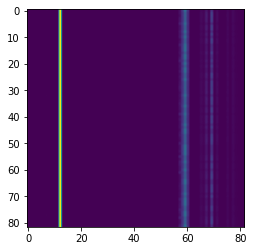

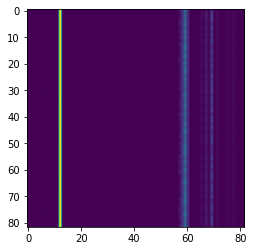

In [33]:
plt.imshow(c670_wt.head(41*2).values)
plt.show()
plt.imshow(c670_wt_gt.head(41*2).values)

In [34]:
predict.model_c670_sf.show_metrics(c670_wt,c670_wt_gt,e=2e-2)

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,1,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,1,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,1,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,1,0,NaN
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1,2.66339e-09,0.00310767
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1,4.46085e-10,0.00296942
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


#C670 OP

In [35]:
c670_op = predict.c670_op(c670_x)
c670_op = c670_op.dropna(axis=0)
c670_op.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
019-029,0.870957,0.871956,323.212585,37.815891,37.56591,182.314758,230.176102
111-070,0.870957,0.871956,323.212585,37.815891,37.56591,182.314758,230.176102
128-064,0.870957,0.871956,323.212585,37.815891,37.56591,182.314758,230.176102
092-092,0.870957,0.871956,323.212585,37.815891,37.56591,182.314758,230.176102
086-098,0.870957,0.871956,323.212585,37.815891,37.56591,182.314758,230.176102


In [36]:
c670_op_gt = predict.c670_df.loc[c670_op.index,c670_op.columns]
c670_op_gt.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
019-029,0.870919,0.872454,293.128082,30.719880,31.821816,182.299377,225.821564
111-070,0.870934,0.873219,255.479691,30.030516,30.272767,181.287079,228.578217
128-064,0.870948,0.873367,227.031448,27.105341,27.176478,181.090942,228.305633
092-092,0.870918,0.873187,270.057251,30.474378,31.047280,181.488922,228.636658
086-098,0.870912,0.873154,242.945587,27.888037,28.346321,181.247436,228.054352


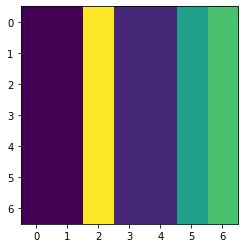

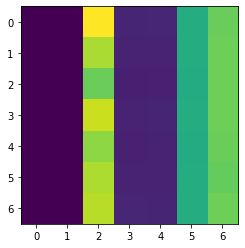

In [37]:
plt.imshow(c670_op.head(7).values)
plt.show()
plt.imshow(c670_op_gt.head(7).values)

In [38]:
predict.model_c670_op.show_metrics(c670_op,c670_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,2.09518e-09,0.00412057
Density_Bottoms Production Rate and Composition,0,8.16214e-07,0.0913137
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0,4569.89,19.4554
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0,71.8208,20.9987
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0,63.1746,19.711
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0,0.824096,0.479656
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0,13.4468,1.42257
AVG,0,674.165,8.8804
